In [1]:
import numpy as np
from scipy.optimize import root_scalar, root
import matplotlib.pyplot as plt
from astropy import units as u

import galpy
from galpy.orbit import Orbit
from galpy import potential as pot
from galpy.util import coords, conversion #for unit conversions

In [2]:
R0 = 8
V0 = 220

# GP_Bulge = pot.PowerSphericalPotentialwCutoff(alpha=1.8, r1=0.075/R0, rc=2.1/R0, ro=R0, vo=V0, normalize=0.05)
# GP_ThinD = pot.DoubleExponentialDiskPotential(hr = 2.5/R0, hz = 0.3/R0, ro=R0, vo=V0, normalize=0.3)
# GP_ThicD = pot.DoubleExponentialDiskPotential(hr = 3.5/R0, hz = 0.9/R0, ro=R0, vo=V0, normalize=0.3)
# GP_Halo  = pot.NFWPotential(a = 1.07/R0, ro=R0, vo=V0, normalize = 0.35)

# MW_Wang = GP_Bulge + GP_ThinD + GP_ThicD + GP_Halo
# for p in MW_Wang:
#     p.plotRotcurve(Rrange=[0.01,30.],grid=1001,overplot=True)
#     plt.xlim(0.1,20)
#     plt.ylim(0.1,200)

In [3]:
# def tidal_radius(Mass_Proj, Radius_Proj, MW_Potential):
#     """
#     Gives the tidal radius for a given projenitor in 
#     the Milky Way potential. Arguments are the predicted
#     masses (with astropy units M_sun) and radius (pc) 
#     from the center of the projenitor as well as a galpy
#     Milky Way potential object. 
    
#     Assumptions:
#     - X = 0 is the center of the Milky Way
#     - Progenitor is on the plane of the disk of the Milky Way (z=0)
#     - The Milky Way Potential is static
#     - The Progenitor is a spherically symmetric mass following an isothermal potential
#     - Stars are stripped at the edge of the virial radius
#     """
#     Potential_Proj = pot.PseudoIsothermalPotential(amp = Mass_Proj, a = Radius_Proj)
    
#     def force(r):
#         #subfunction that gives net force based on two potentials
#         F_Proj = pot.evaluateRforces(Potential_Proj, Radius_Proj, 0)*conversion.force_in_pcMyr2(V0,R0)
#         F_MW = pot.evaluateRforces(MW_Potential, r, 0)*conversion.force_in_pcMyr2(V0,R0)
#         return F_MW - F_Proj #Projenitor force is antiparallel to Milky Way force (so opp. sign)
    
#     sol = root_scalar(force, method="bisect", x0=1e5, bracket=[1e1,1e20], xtol=1e3)
#         #solves for root using bisect method. Tolerance is within a kiloparsec
#         if sol.converged == False:
#             print(f"The solution for {m_proj} solar masses didn't converge!")
#         sols.append(sol.root)
        
#     return np.asarray(sols)
#     #return sol.x

# #Mateo et al. 2008
# M_leo = 7e8*u.Msun #virial mass in M_sun
# R_leo = 18.3e3*u.pc #virial radius in kpc

# #r_tidal = tidal_radius([0.5e10], R_leo, MW_Wang)

In [33]:
def tidal_radius(Proj_Potential, MW_Potential, dist):
    """
    Gives the tidal radius for a given projenitor in 
    the Milky Way potential. Arguments are galpy 
    potentials of the projenitor and the Milky Way,
    as well as the distance (dist) of stars from the
    center of the projenitor (should be Quantity object).
    
    Assumptions:
    - X = 0 is the center of the Milky Way
    - Progenitor is on the plane of the disk of the Milky Way (z=0)
    - Potentials are static and represented by simple analytic forms
    """
    #1) Need a function to describe the force by the two potentials at the tidal distance
    def force(r):
        #subfunction that gives net force based on two potentials
        F_Proj = pot.evaluateRforces(Proj_Potential, dist, 0)*conversion.force_in_pcMyr2(V0,R0)
        F_MW = pot.evaluateRforces(MW_Potential, r, 0)*conversion.force_in_pcMyr2(V0,R0)
        return F_MW - F_Proj #Projenitor force is antiparallel to Milky Way force (so opp. sign)
    
    #2) For it to be a tidal distance, the force should be 0
    sol = root_scalar(force, method="bisect", x0=1e5, bracket=[1e1,1e20], xtol=1e2)
    #solves for root using bisect method. Tolerance is within a kiloparsec
    if sol.converged == False:
        print(f"The solution for {m_proj} solar masses didn't converge!")
        
    #3) Give back that tidal distance
    return sol.root
    #return sol.x

def tidal_radii_iso(Masses, R, Core_Proj, MW_Potential, Plot):
    tidal_rads = []
    
    for M in Masses:
        Proj_Potential = pot.PseudoIsothermalPotential(amp = M, a = Core_Proj, normalize = False)
        r = tidal_radius(Proj_Potential, MW_Potential, R)
        tidal_rads.append(r)
    
    tidal_rads = np.asarray(tidal_rads)
    if Plot == True:
        print("Plot Commencing")
        plt.plot(Masses.value/(1e10), tidal_rads/(1e3), label = f"Star at {R/1e3} kpc")
        plt.xlabel(r"Mass [$10^{10} \mathrm{M}_{\odot}$]")
        plt.ylabel(r"Tidal Radii [$\mathrm{kpc}$]")
        
    if Plot == False:
        print("No Plot Requested")
    
    return tidal_rads

In [34]:
R_Leo = 18.3e3*u.pc #virial radius in pc
Rs_Leo = [R_Leo, 2*R_Leo, 3*R_Leo]
Mstar_Leo = np.linspace(0.5e10,2.1e10, 321)*u.Msun

# LeoPotential = pot.PseudoIsothermalPotential(amp = 1.3e10*u.Msun, a = 1e3*u.kpc, normalize = False)

# rs = tidal_radius(LeoPotential,pot.MWPotential2014, R_Leo)
# print(rs)

r = []
for R in Rs_Leo:
    r.append(tidal_radii_iso(Mstar_Leo, R, 4e3*u.kpc, pot.MWPotential2014, Plot=True))
all_rs = np.asarray(r)
#print(all_rs)
plt.legend()

NameError: name 'Proj_Pontential' is not defined

In [ ]:
# #Mateo et al. 2008
# M_leo = 7e8 #virial mass in M_sun
# R_leo = 18.3e3 #virial radius in kpc

# #r_tidal = tidal_radius([0.5e10], R_leo, MW_Wang)

# # Mstar_Leo = np.linspace(0.5e10,2.1e10, 65)
# # r_tidals = tidal_radius(Mstar_Leo, R_leo, MW_Wang)

# # print(r_tidals)

# Mstar_Leo = np.linspace(0.5e10,2.1e10, 321)

# #r_tidal = tidal_radius(Mstar_Leo, R_leo, MW_Wang)

# r_tidals = []
# Rs_Leo = [R_leo, 2*R_leo, 3*R_leo]
# for R in Rs_Leo: 
#     r_tidals.append(tidal_radius(Mstar_Leo, R, MW_Wang))

# fig, ax = plt.subplots()
# for i in range(0,3):
#     plt.plot(Mstar_Leo/(1e10), r_tidals[i]/(1e3), label=f"{i+1} Virial Rad")
#     plt.xlabel(r"Mass [$10^{10} \mathrm{M}_{\odot}$]")
#     plt.ylabel(r"Tidal Radius [$\mathrm{kpc}$]")
#     plt.legend()

In [22]:
#Parameter Block
#Orbit Initial Conditions
orb = Orbit.from_name('Leo I')
orb_df = Orbit.from_name('Leo I')

ts = np.linspace(0,-4,101)*u.Gyr #every 10Myr

#No DF orbit
orb.integrate(ts, pot.MWPotential2014)

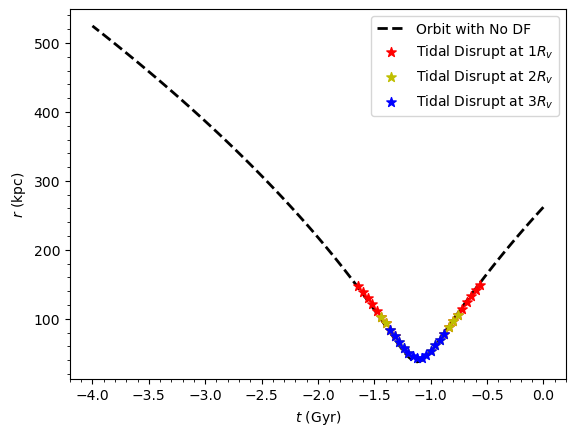

In [28]:
orb.plot(d1='t',d2='r', color="k", linewidth=2, linestyle="dashed", label=r'Orbit with No DF')

def tidal_times(rad_ind):
    times = []
    for t in ts:
        r = orb.dist(t)*1e3
        r_max = all_rs[rad_ind][0]
        r_min = all_rs[rad_ind][-1]
       # print(r, min(r_min,r_max), max(r_min,r_max))
        if min(r_min,r_max) < r < max(r_min,r_max):
        #    print("here",t.value)
            times.append(t.value)
    return np.asarray(times)
    
for i in range(len(Mstar_Leo.value-1)):
    R2_times = tidal_times(1)
    R3_times = tidal_times(2)
    #print(R1_time)
    #print(R1_time, R3_time)
    R1_times = tidal_times(0)
#    print(R1_times)

R1dists = []
for times in R1_times:
    R1dists.append(orb.dist(times*u.Gyr))  
R2dists = []
for times in R2_times:
    R2dists.append(orb.dist(times*u.Gyr))
R3dists = []
for times in R3_times:
    R3dists.append(orb.dist(times*u.Gyr))  

plt.scatter(R1_times, R1dists, marker = "*", color = "r", s = 50, zorder=10, label = r"Tidal Disrupt at $1 R_v$")    
plt.scatter(R2_times, R2dists, marker = "*", color = "y", s = 50, zorder=10, label = r"Tidal Disrupt at $2 R_v$")
plt.scatter(R3_times, R3dists, marker = "*", color = "b", s = 50, zorder=10, label = r"Tidal Disrupt at $3 R_v$")
plt.legend()
#Dynamical Friction Properties 
# Mass_lowres = np.linspace(0.5e10,2.1e10, 9)*u.Msun
# for m in Mass_lowres:
#     DF = pot.ChandrasekharDynamicalFrictionForce(GMs=m,rhm=0.5*u.kpc, dens=MW_Wang)
#     orb_df.integrate(ts, MW_Wang+DF)
#     orb_df.plot(d1='t',d2='r', linewidth=1, label=f'DF with Mass {m/1e10} 10^10 Solar Masses', overplot=True)